# On using `dask` arrays for out-of-core computation
* **A sample, applying a uniform filter to an image, illustrating with and without dask arrays**
* This notebook is based on [this](https://github.com/dask/dask-examples/blob/master/image-filtering.ipynb) other notebook illustrating dask from the dask people

## Imports and mean function
* Using `scipy`'s `uniform_filter`

In [16]:
# Set up graphing and perform imports
%matplotlib inline
import matplotlib.pyplot as plt

import os # for os.join to read file
import numpy as np
from scipy.ndimage import uniform_filter
import dask.array as da

# this will be our test function
def mean(img):
    "ndimage.uniform_filter with `size=51`"
    return uniform_filter(img, size=51)

## Grab our input and do some preprocessing

In [17]:
!ls images

a_query.jpg             hummingbird_mharris.jpg tents.png
baboon.jpg              lodge.tif               warsketch.png
baboon.png              segmented_bird.png      warsketch.tif
cuba.png                segmented_bird2.png     whidbey_mharris.jpg
cuba.tif                tents.jpg


### Use `Pillow` to convert an image to png
* png format needed by `matplotlib`'s `imread`

In [18]:
# Convert a jpeg to png with Pillow
from PIL import Image

# file names (in images folder)
imagein = os.path.join('images', 'cuba.tif')
imageout = os.path.join('images', 'cuba.png')


if not os.path.exists(imageout):
    # convert out jpeg to png
    img = Image.open(imagein)
    img.save(imageout)

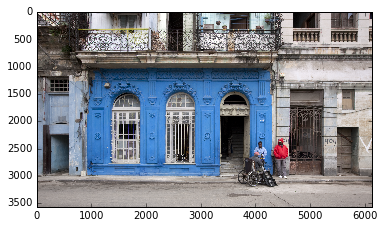

In [19]:
# Peek at converted image
img = plt.imread(imageout)
plt.imshow(img)

### Read image and grab one channel

'21.0 Mega pixels, shape (3564, 6127), dtype uint8'

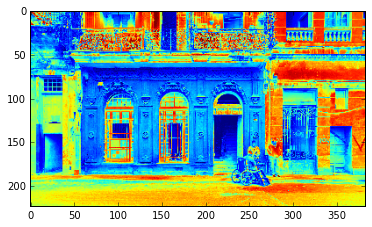

In [20]:
# Read image data into numpy ndarray
import os

img = plt.imread(imageout)

# Take only first of 3 channels
img = (img[:,:,0] * 255).astype(np.uint8)

plt.imshow(img[::16, ::16])

# Get size and shape
mp = str(img.shape[0] * img.shape[1] * 1e-6 // 1)
'%s Mega pixels, shape %s, dtype %s' % (mp, img.shape, img.dtype)

## Directly filtering vs. `dask` with one big chunk

### No `dask` (direct filter)

CPU times: user 356 ms, sys: 16.3 ms, total: 372 ms
Wall time: 522 ms


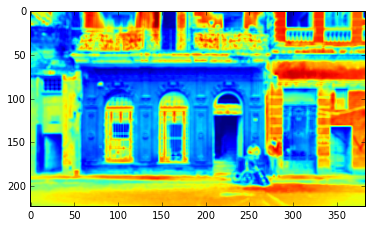

In [21]:
# filter directly
%time mean_nd = mean(img)

# mean_nd = mean(img)
plt.imshow(mean_nd[::16, ::16])

### `dask` with one big chunk

In [22]:
# Dask array creation - one chunk ONLY
img_da = da.from_array(img, chunks=img.shape)

CPU times: user 398 ms, sys: 25.1 ms, total: 423 ms
Wall time: 439 ms


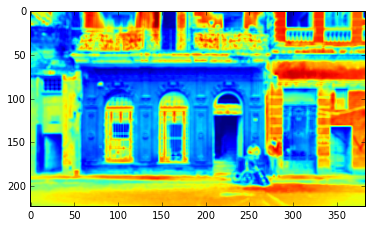

In [23]:
# This should be about same as direct filter above - compute called to start computation
%time mean_da = img_da.map_overlap(mean, depth=0).compute()

mean_da = img_da.map_overlap(mean, depth=0).compute()
plt.imshow(mean_da[::16, ::16])

## Multiple chunks and overlap with `dask` arrays

In [24]:
# How many cores to we have on this computer
from multiprocessing import cpu_count
cpu_count()

4

In [25]:
img.shape, mean_da.shape, mean_nd.shape

((3564, 6127), (3564, 6127), (3564, 6127))

In [26]:
# original pixel counts in chunk
# img_da.chunks

In [27]:
# Function to plot edges in original, dask chunks and difference 
#  - shows smoothness in image information boundaries from analysis
def show_edges():
    chunk_size = chunk_sizes
    size = 50
    mask = np.index_exp[chunk_size[0]-size:chunk_size[0]+size, chunk_size[1]-size:chunk_size[1]+size]
    
    # Plots
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mean_nd[mask]) # filtered directly
    plt.subplot(132)
    plt.imshow(mean_da[mask]) # filtered in chunks with dask
    plt.subplot(133)
    plt.imshow(mean_nd[mask] - mean_da[mask]); # difference

### Multiple chunks and *no* overlap

In [28]:
# Split into 4 - so, 2x2

import math
x, y = img.shape

r = math.ceil(x / 2)
c1 = math.ceil(y / 2)

chunk_sizes = (r, c1)
print(chunk_sizes)

%time img_da = da.rechunk(img_da, chunks = chunk_sizes)
print(img_da.chunks)

(1782, 3064)
CPU times: user 313 µs, sys: 8 µs, total: 321 µs
Wall time: 326 µs
((1782, 1782), (3064, 3063))


CPU times: user 385 ms, sys: 49.1 ms, total: 434 ms
Wall time: 207 ms


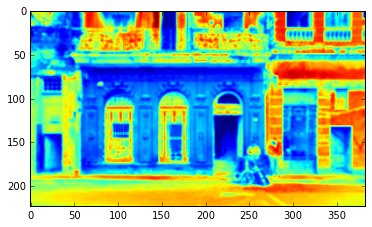

In [29]:
# Check to see if it's faster with multiple chunks
%time mean_da = img_da.map_overlap(mean, depth=0).compute()

mean_da = img_da.map_overlap(mean, depth=0).compute()
plt.imshow(mean_da[::16, ::16])

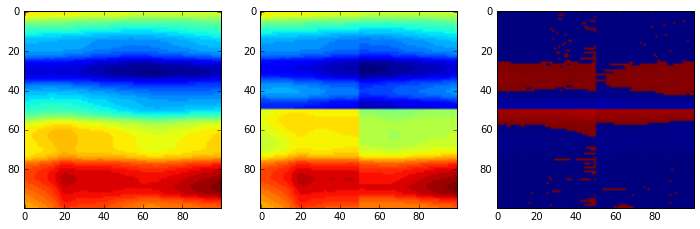

In [30]:
show_edges()

### Multiple chunks *with* overlap

((1782, 1782), (3064, 3063))
CPU times: user 454 ms, sys: 46.2 ms, total: 500 ms
Wall time: 209 ms


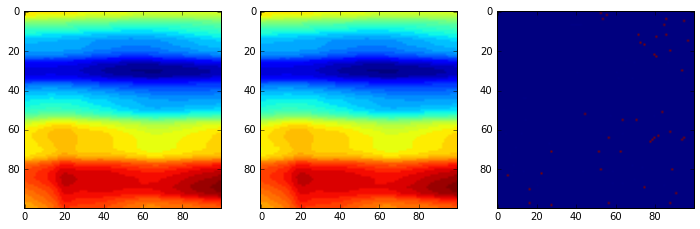

In [31]:
# allow for overlapping pixels (depth > 0)
print(img_da.chunks)
%time mean_da = img_da.map_overlap(mean, depth=25).compute()

mean_da = img_da.map_overlap(mean, depth=25).compute()
show_edges()

### Smaller chunks without and with overlap

In [32]:
# Split into 16 - so, 4x4

import math
r = math.ceil(x / 4)
c1 = math.ceil(y / 4)

chunk_sizes = (r, c1)
print(chunk_sizes)

img_da = da.rechunk(img_da, chunks = chunk_sizes)
print(img_da.chunks)

(891, 1532)
((891, 891, 891, 891), (1532, 1532, 1532, 1531))


#### Without overlap

CPU times: user 356 ms, sys: 59 ms, total: 415 ms
Wall time: 202 ms


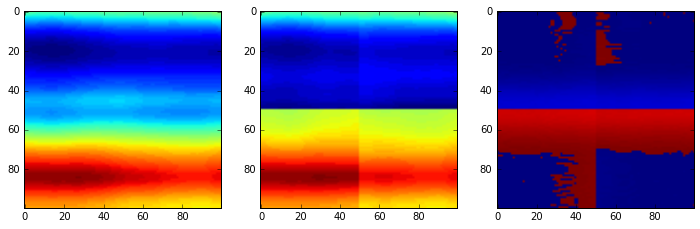

In [33]:
%time mean_da = img_da.map_overlap(mean, depth=0).compute()

mean_da = img_da.map_overlap(mean, depth=0).compute()
show_edges()

#### With overlap
* What do we gain and what do we loose?
* Is this faster or slower than the original filter and why?

CPU times: user 449 ms, sys: 56.7 ms, total: 506 ms
Wall time: 279 ms


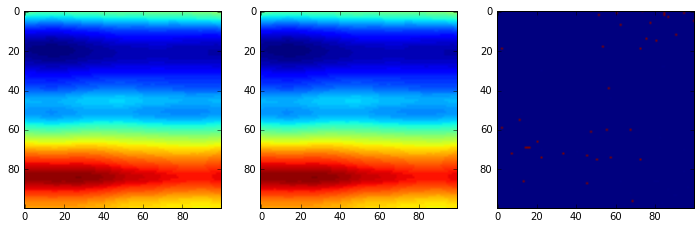

In [34]:
%time mean_da = img_da.map_overlap(mean, depth=25).compute()

mean_da = img_da.map_overlap(mean, depth=25).compute()
show_edges()